In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

 ## Połączenie z bazą danych
 

In [2]:
username = 'postgres'
password = 'postgres'

host = 'localhost'
database = 'airline'
port = 5432

In [3]:
url = f'postgresql://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(url)

In [4]:
def read_sql_table(table_name):
    msg = f"Pobieram dane z tabeli: {table_name}"
    print(msg)

    df = pd.read_sql(table_name, engine)
    return df

In [5]:
flight_df = pd.read_csv(
    '../data/processed/flight_df_01.csv', 
    sep=';')

In [6]:
flight_df_expected_rows_amount = 1057391
flight_df_rows_amount = flight_df.shape[0]

assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

 # Wzbogacenie o `aircraft`


In [7]:
aircraft_df = read_sql_table('aircraft')

Pobieram dane z tabeli: aircraft


In [8]:
aircraft_df = aircraft_df[['tail_num', 'manufacture_year']].drop_duplicates()

 ### Sprawdzenie


In [9]:
aircraft_df_expected_rows = 7364
aircraft_df_expected_columns = set(['tail_num', 'manufacture_year'])

aircraft_df_rows = aircraft_df.shape[0]

diff = aircraft_df_expected_columns.symmetric_difference(set(aircraft_df.columns))
assert aircraft_df_rows == aircraft_df_expected_rows, f'Spodziewano się {aircraft_df_expected_rows} wierszy , otrzymano {aircraft_df_rows} wierszy'

assert diff == set([]), f'Spodziewano się {aircraft_df_expected_columns} kolumn, otrzymano: {aircraft_df_expected_columns} kolumn. Różnica: \n\t{diff}'

In [10]:
aircraft_df_is_duplicated = aircraft_df.duplicated(subset='tail_num')
aircraft_df_duplicated = aircraft_df.loc[aircraft_df_is_duplicated]

 ### Sprawdzenie


In [11]:
aircraft_df_expected_rows = 3
aircraft_df_duplicated_rows = aircraft_df_duplicated.shape[0]
assert aircraft_df_duplicated_rows == aircraft_df_expected_rows, f"Oczekiwano {aircraft_df_expected_rows} wierszy, otrzymano {aircraft_df_duplicated_rows}"

 ## Modyfikacja `aircraft_df`


In [12]:
aircraft_df = (aircraft_df
               .groupby(by='tail_num', as_index=False)['manufacture_year']
               .max()
               )
aircraft_df

tail_num  manufacture_year
0      B708RE              2006
1       CFEXB              1996
2       CFEXF              1996
3       CFEXH              1987
4       CFEXI              1987
...       ...               ...
7356   ZS-JIV              1976
7357   ZS-OPS              1978
7358   ZS-RSC              1972
7359   ZS-RSF              1974
7360   ZS-RSG              1974

[7361 rows x 2 columns]

 ### Sprawdzenie


In [13]:
test_tail = 'N783CA'
test_value = aircraft_df.loc[aircraft_df['tail_num']
                             == test_tail]['manufacture_year']
test_value = int(test_value)

expected_value = 2000
assert test_value == expected_value, f"Dla 'tail_num' == '{test_tail}' oczekiwano {expected_value} otrzymano {test_value}"

 ## Połączenie `aircraft_df` oraz `flight_df`


 Tutaj dokonaj złączenia `flight_df` z `aircraft_df`, wynik zapisz do `tmp_flight_df`

In [14]:
tmp_flight_df = pd.merge(
    left=flight_df,
    right=aircraft_df,
    how='left',
    on='tail_num'
)

In [15]:
flight_df.shape[0] == tmp_flight_df.shape[0]

True

In [16]:
flight_df = tmp_flight_df.copy()

 ## Opóźnienia vs. rok produkcji samolotu cz. 1


In [17]:
delays_by_manufacture_year_df = (flight_df
                                 .groupby(by='manufacture_year', as_index=False)
                                 .agg({'is_delayed': ['mean', 'size']})
                                 )
delays_by_manufacture_year_df

manufacture_year is_delayed        
                          mean    size
0            1987.0   0.126411     443
1            1988.0   0.181388     634
2            1989.0   0.153846      13
3            1990.0   0.155453    4786
4            1991.0   0.181795    7701
5            1992.0   0.176055   13882
6            1993.0   0.187882    5562
7            1994.0   0.232518    5191
8            1995.0   0.194024    7731
9            1996.0   0.190382   12186
10           1997.0   0.207543    9121
11           1998.0   0.178461   40317
12           1999.0   0.198373   44018
13           2000.0   0.187512   58215
14           2001.0   0.154113  100251
15           2002.0   0.212610   35845
16           2003.0   0.187752   21081
17           2004.0   0.181390   43266
18           2005.0   0.200692   41621
19           2006.0   0.224261   44952
20           2007.0   0.216644   37804
21           2008.0   0.202871   48558
22           2009.0   0.210442   26278
23           2010.0   0.211565   20977
24           2011.0   0.220629   23084
25           2012.0   0.196010   32728
26           2013.0   0.190144   40543
27           2014.0   0.178658   61128
28           2015.0   0.189214   58426
29           2016.0   0.186717   66191
30           2017.0   0.187289   62353
31           2018.0   0.189888   47370
32           2019.0   0.193516   22918

In [18]:
plt.scatter(
    x=delays_by_manufacture_year_df['manufacture_year'],
    y=delays_by_manufacture_year_df[('is_delayed', 'mean')],
    c=delays_by_manufacture_year_df[('is_delayed', 'size')]
)

Text(0.5, 0, 'Rok produkcji samolotu')

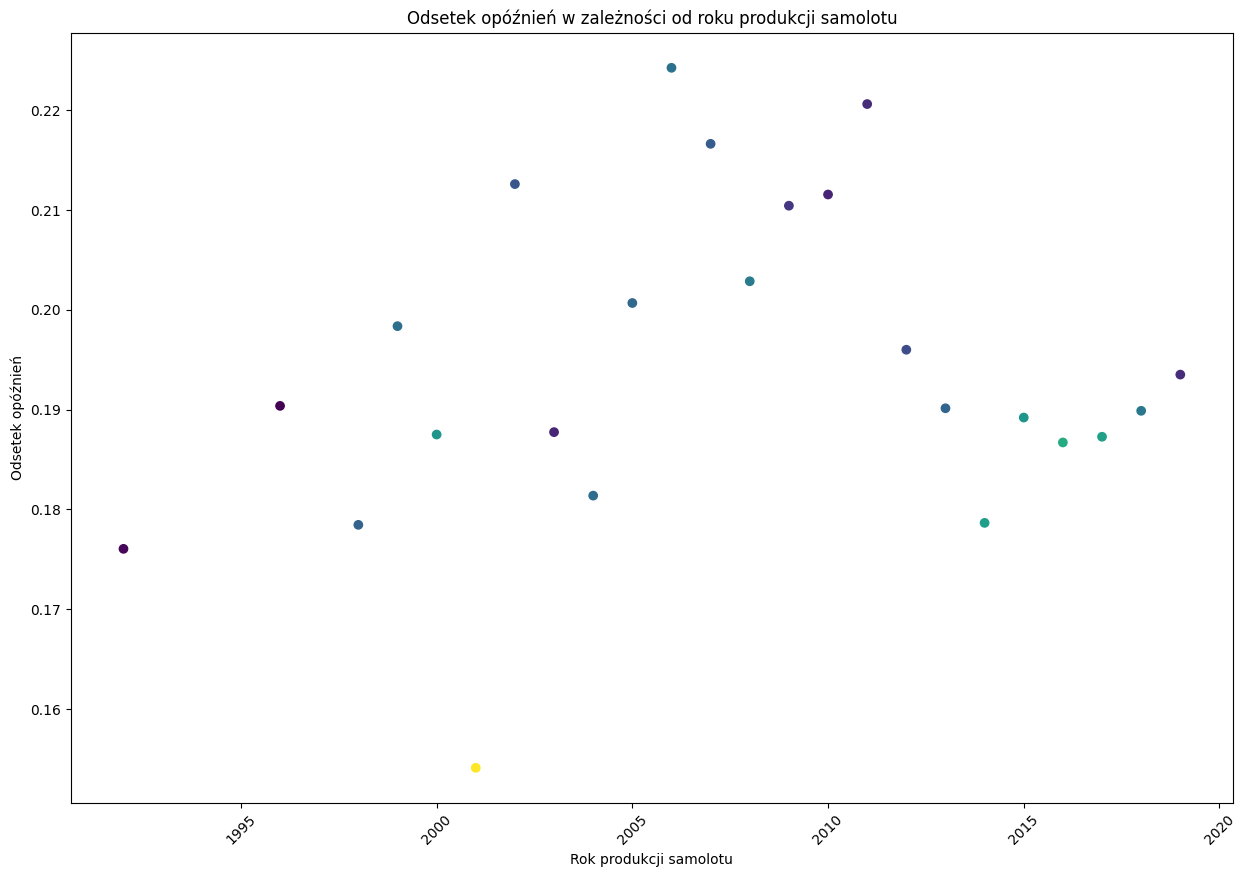

In [19]:
delays_by_manufacture_year_df_over_10000 = delays_by_manufacture_year_df[
    ('is_delayed', 'size')] > 10000
to_plot = delays_by_manufacture_year_df.loc[delays_by_manufacture_year_df_over_10000]

plt.figure(figsize=(15, 10))

plt.scatter(
    x=to_plot['manufacture_year'],
    y=to_plot[('is_delayed', 'mean')],
    c=to_plot[('is_delayed', 'size')]
)

plt.title("Odsetek opóźnień w zależności od roku produkcji samolotu")
plt.ylabel("Odsetek opóźnień")

plt.xticks(rotation=45)
plt.xlabel("Rok produkcji samolotu")

 ## Opóźnienia vs. rok produkcji samolotu cz. 2


In [20]:
flight_df['manufacture_year_agg'] = pd.cut(
    x=flight_df['manufacture_year'],
    bins=range(1990, 2021, 3)
)

In [21]:
flight_delays_by_manufacture_year_agg_df = (flight_df
                                     .groupby(by='manufacture_year_agg')['is_delayed']
                                     .agg(['mean', 'size'])
                                     )
flight_delays_by_manufacture_year_agg_df

mean    size
manufacture_year_agg                  
(1990, 1993]          0.180107   27145
(1993, 1996]          0.200215   25108
(1996, 1999]          0.190678   93456
(1999, 2002]          0.174910  194311
(2002, 2005]          0.190237  105968
(2005, 2008]          0.214158  131314
(2008, 2011]          0.214120   70339
(2011, 2014]          0.186348  134399
(2014, 2017]          0.187688  186970
(2017, 2020]          0.191071   70288

In [22]:
plt.figure(figsize=(15, 10))

plt.scatter(
    x=flight_delays_by_manufacture_year_agg_df.index.astype(str),
    y=flight_delays_by_manufacture_year_agg_df['mean'],
    c=flight_delays_by_manufacture_year_agg_df['size']
)

plt.title("Odsetek opóźnień w zależności od roku produkcji samolotu")
plt.ylabel("Odsetek opóźnień")

plt.xticks(rotation=45)
plt.xlabel("Rok produkcji samolotu")

Text(0.5, 0, 'Rok produkcji samolotu')

In [23]:
top_manufactured_df = (delays_by_manufacture_year_df
                       .sort_values(by=[('is_delayed', 'size')], ascending=False)
                       .head(5)
                       )
top_manufactured_df

manufacture_year is_delayed        
                          mean    size
14           2001.0   0.154113  100251
29           2016.0   0.186717   66191
30           2017.0   0.187289   62353
27           2014.0   0.178658   61128
28           2015.0   0.189214   58426

Zapis ramki

In [24]:
flight_df.to_csv('../data/processed/flight_df_02.csv', sep=';')